In [6]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [7]:
def semantic_similarity(sentence1, sentence2):
    #Compute embedding for both lists
    embedding_1= model.encode(sentence1, convert_to_tensor=True)
    embedding_2 = model.encode(sentence2, convert_to_tensor=True)

    similarity = util.pytorch_cos_sim(embedding_1, embedding_2)
    return similarity.item()


# sentences = ["I love the taste of icecream", "The taste of icecream is delicious"]
# embeddings = model.encode(sentences)

# #Compute embedding for both lists
# embedding_1= model.encode(sentences[0], convert_to_tensor=True)
# embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

# similarity = util.pytorch_cos_sim(embedding_1, embedding_2)
# print(similarity)

In [ ]:
test = semantic_similarity("I am happy", "I am filled with happiness")

In [ ]:
test

In [24]:
import psycopg2
from psycopg2.extras import RealDictCursor

connection = psycopg2.connect(
    user="postgres",
    password="pje",
    host="localhost",
    port="5432",
    database="llm_experiments",
)

def get_tests():
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        select * from ubuntu_manual_tests.test t
    '''

    cursor.execute(query)
    tests = cursor.fetchall()
    cursor.close()
    
    return tests

def get_test_steps(test_id):
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        select * from ubuntu_manual_tests.test_steps ts
        where ts.test_id = %s
    '''

    cursor.execute(query, (test_id,))
    steps = cursor.fetchall()
    cursor.close()
    
    return steps

def get_first_header(test_id):
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        select * from ubuntu_manual_tests.test_headers th
        where th.test_id = %s
    '''

    cursor.execute(query, (test_id,))
    headers = cursor.fetchall()
    cursor.close()
    
    return headers[0]

def insert_gen_reactions(verification, step_id, action, origin_verification, model="TheBloke/Llama-2-7B-Chat-GGUF", similarity=0):
        
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        insert into ubuntu_manual_tests.generated_step_reactions (verification, step_id, model, action, original_verification, semantic_similarity) values (%s, %s, %s, %s, %s, %s)
    '''
    cursor.execute(query, (str(verification), step_id, model, str(action), str(origin_verification), similarity))
    connection.commit()
    cursor.close()
    
def get_gen_reactions():
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        select * from ubuntu_manual_tests.generated_step_reactions g
    '''

    cursor.execute(query)
    tests = cursor.fetchall()
    cursor.close()
    
    return tests

def update_semantic_similarity(gen_id, similarity):
        
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    query = '''
        update ubuntu_manual_tests.generated_step_reactions set semantic_similarity = %s where id = %s
    '''
    cursor.execute(query, (similarity, gen_id))
    connection.commit()
    cursor.close()

In [1]:
# Example: reuse your existing OpenAI setup
from openai import OpenAI

# Point to the local server
def get_response(prompt, llm_model="QuantFactory/Meta-Llama-3-8B-Instruct-GGUF"): 
    client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

    completion = client.chat.completions.create(
    model=llm_model,
    messages=[
        {"role": "system", "content": "Always answer only with a single sentence string with no other texts"},
        {"role": "user", "content": prompt},
    ],
    temperature=0.7,
    )
    return completion.choices[0].message.content

In [16]:
def gen_prompt(precondition, action):
    #precondition = 'Network connections'
    #action = 'If you have access to several methods to connect to Internet, try to connect with them all'

    prompt = f'''
        Consider a manual test which has a precondition and a list of steps with actions and verifications. Given the precondition '{str(precondition)}', complete a test step generating the reaction for the following action: '{str(action)}'. Only generate the verification in one line and return it in raw text
    '''
    return prompt

In [ ]:
texts = gpt.gen_text_by_prompt(text=prompt, max_length=100, qnt_sentences=3)

In [ ]:
print(texts[0]['generated_text'])

In [ ]:
resp = get_response(prompt)
print(resp)

In [ ]:
tests = get_tests()

In [ ]:
print(tests[0])

In [ ]:
steps = get_test_steps(tests[0]['id'])

In [3]:
verific = get_response(gen_prompt('Screensaver', 'Go to Applications ->Settings Manager ->Screensaver'))

In [4]:
verific

'Verification: The Screensaver settings are updated successfully.'

In [ ]:
for step in steps:
    print(step)

In [ ]:
headers = get_first_header(tests[0]['id'])

In [ ]:
print(headers)

In [18]:
tests = get_tests()
gen_reactions_tests = []
cont = 0
for i, test in enumerate(tests):
    steps = get_test_steps(test['id'])
    header = get_first_header(test['id'])
    for step in steps:
        gen_verification = get_response(gen_prompt(str(header), str(step['action'])))
        gen_verification = gen_verification.replace('Verification:', '')
        similarity = semantic_similarity(str(step['verification']), gen_verification)
        print(f"{cont} - action: {step['action']} | veri: {gen_verification} | sim: {similarity}")
        insert_gen_reactions(gen_verification, step['id'], step['action'], step['verification'], model="QuantFactory/Meta-Llama-3-8B-Instruct-GGUF")
        cont+=1

0 - action: Log in with the Xubuntu session | veri: The verification "logged in successfully" is verified. | sim: 0.1061217337846756
1 - action: Open Ubuntu Software Center and install applications you would like to use | veri: The verification is "Software Center displays installed applications grid with two rows". | sim: 0.5497409105300903
2 - action: If you have a USB drive, plug it in | veri:  "The system's disk drive icon should display a removable disk symbol" | sim: 0.4029528498649597
3 - action: If you have a DVD or an audio CD, insert it | veri:  "Please ensure your disc is properly inserted." | sim: 0.3893446922302246
4 - action: Log out, shutdown or restart | veri: Here is the completed test step with the generated reaction: "Verification passed" for the action 'Log out, shutdown or restart'" with precondition 'RealDictRow([('id', 2), ('test_id', 3), ('header_text', ''))]'". | sim: 0.3094384968280792
5 - action: Open a text editor and write some text | veri: Here is the comp

In [ ]:
import strsimpy

In [ ]:
from strsimpy.levenshtein import Levenshtein

levenshtein = Levenshtein()
print(levenshtein.distance('My string', 'My string'))
print(levenshtein.distance('My string', 'My $string'))
print(levenshtein.distance('My string', 'My $string'))

In [ ]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()
print(normalized_levenshtein.distance('My string', 'My string'))
print(normalized_levenshtein.similarity('My string', 'My string'))

In [ ]:
from strsimpy.cosine import Cosine

cosine = Cosine(2)
s0 = "I am happy"
s1 = "I am filled with happiness"
p0 = cosine.get_profile(s0)
p1 = cosine.get_profile(s1)
cosine
print(cosine.similarity_profiles(p0, p1))


In [20]:
gen_reactions = get_gen_reactions()

In [21]:
for i, gen in enumerate(gen_reactions):
    #print(gen['id'], ' - ', gen['original_verification'], ' | ', gen['verification'].replace('Verification:', ''))
    similarity = semantic_similarity(gen['original_verification'], gen['verification'].replace('Verification:', ''))
    update_semantic_similarity(gen['id'], similarity)
    print(f"{i} - {similarity} - {gen['original_verification']} | {gen['verification'].replace('Verification:', '')}")

0 - 0.01531533058732748 - [] | The test step generates "partition_scheme selected" with verification "partition_scheme selected as expected".
1 - 0.03036319836974144 - [] | The verification is: "The iSCSI target IP address is correctly displayed."",
2 - -0.0002977866679430008 - [] |  assert actual == expected.
3 - -0.020104071125388145 - [] | The test step is "action Enter the username configured in the iSCSI target, verification 'username' should contain the correct value".
4 - -0.018233932554721832 - [] | The verification "Send the 'iscsi_login' command to verify the login success" is returned.
5 - 0.024273954331874847 - [] |  assert "target_selected" is True.
6 - 0.02818959206342697 - [] | The verification result is "Action failed with error message".
7 - 0.04584664851427078 - [] | The verification would be " 'assert that selected finish is displayed as expected'"!
8 - 0.02812355011701584 - [] | Verification result: "Partition selected successfully"!
9 - -0.026086581870913506 - [] |

<Axes: >

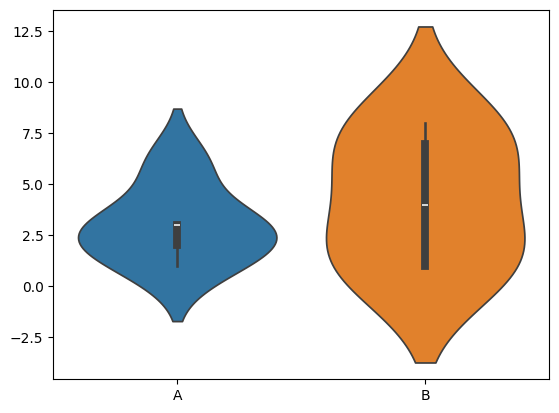

In [23]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'A': [1, 2, 3, 3, 6], 'B': [1, 1, 4, 7, 8]})
sns.violinplot(data=df)

In [25]:
gen_reactions = get_gen_reactions()

In [27]:
df = pd.DataFrame(gen_reactions)

In [29]:
model1 = df[df['model'] == 'TheBloke/Llama-2-7B-Chat-GGUF']

In [35]:
model2 = df[df['model'] == 'QuantFactory/Meta-Llama-3-8B-Instruct-GGUF'].drop_duplicates(subset=['step_id'])

In [39]:
model1.semantic_similarity

0          0.5548985600471497
1        0.028717678040266037
2          0.0485159233212471
3          0.0686517208814621
4         0.28396546840667725
                ...          
6809       0.5430999994277954
6810    -0.021726340055465698
6811       0.0790136530995369
6812     -0.04021322727203369
6813       0.4283831715583801
Name: semantic_similarity, Length: 6598, dtype: object

In [51]:
plot_df = pd.DataFrame({'Llama-2-7B-Chat-GGUF': model1.semantic_similarity, 'Meta-Llama-3-8B-Instruct-GGUF': model2.semantic_similarity})

#sns.violinplot(data=plot_df, x='model', y='similarity')

In [41]:
plot_df

,TheBloke/Llama-2-7B-Chat-GGUF,QuantFactory/Meta-Llama-3-8B-Instruct-GGUF
0,0.5548985600471497,NaN
1,0.028717678040266037,NaN
2,0.0485159233212471,NaN
3,0.0686517208814621,NaN
4,0.28396546840667725,NaN
...,...,...
13194,NaN,-0.025348834693431854
13195,NaN,-0.05113578587770462
13196,NaN,-0.0002986490726470947
13197,NaN,-0.03320833295583725


<Axes: >

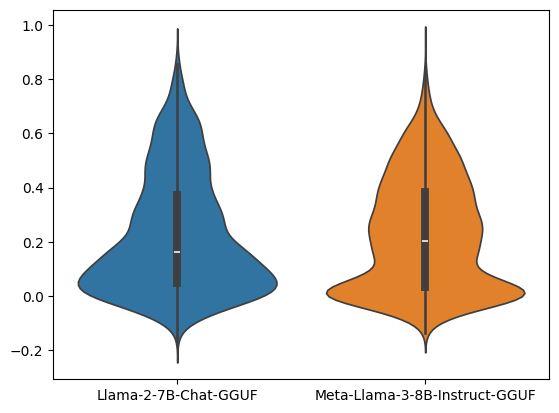

In [52]:
sns.violinplot(data=plot_df)